# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model(std=1e-1):  # use 1e-1 for sanity checks below
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=std)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

toy_net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = toy_net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720496109664e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [4]:
loss, _ = toy_net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.794120407794253e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = toy_net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: toy_net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, toy_net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.669858e-09
b1 max relative error: 2.738422e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 3.865028e-11


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

Final training loss:  1.0985707836544867


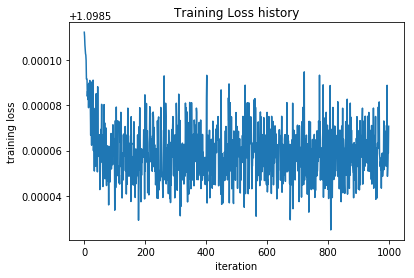

In [6]:
toy_net = init_toy_model(std=1e-4)
stats = toy_net.train(X, y, X, y,
            learning_rate=1e-4, reg=5e-4,
            num_iters=1000, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302941
iteration 100 / 1000: loss 2.302189
iteration 200 / 1000: loss 2.296780
iteration 300 / 1000: loss 2.258834
iteration 400 / 1000: loss 2.192177
iteration 500 / 1000: loss 2.128762
iteration 600 / 1000: loss 2.055003
iteration 700 / 1000: loss 2.017770
iteration 800 / 1000: loss 1.919076
iteration 900 / 1000: loss 1.931012
Validation accuracy:  0.283


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

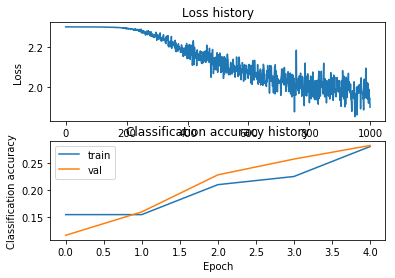

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

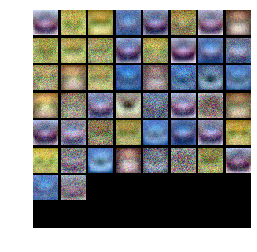

In [10]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that **the model we used has low capacity, and that we should increase its size**. On the other hand, with **a very large model we would expect to see more overfitting**, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including **hidden layer size, learning rate, numer of training epochs, and regularization strength**. You might also consider tuning the **learning rate decay**, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$

In [11]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from copy import deepcopy
results = {}
best_val = 0
best_net = None

# hyperpameters tunning with grid search
learning_rates = np.array([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
hidden_size = np.arange(50,300,50)
regularization_strengths = np.append(np.arange(1,9,2), np.arange(10,100,10))
regularization_strengths = np.append(regularization_strengths, np.arange(100,2000,100))
print('hidden layer size: ', hidden_size)
print('learning_rates: ', learning_rates)
print('regularization_strengths: ', regularization_strengths)
print()

# premable
num_lr = learning_rates.shape[0]
num_reg = regularization_strengths.shape[0]
num_hiddensize = hidden_size.shape[0]
num_iters = 1500
N, D = X_train.shape
num_classes = 10
loss_hist_val = np.zeros((num_lr*num_reg*num_hiddensize, num_iters))
counter = 0  # initialize counter

for hiddensize in hidden_size:
    for lr in learning_rates:
        for reg in regularization_strengths:
            
            # define a new object of class: TwoLayerNet
            two_layer_net = TwoLayerNet(D, hiddensize, num_classes) 
            
            # train neural net
            stats = two_layer_net.train(X_train, y_train, X_val, y_val,
                                            num_iters=num_iters, batch_size=200,
                                            learning_rate=lr, learning_rate_decay=0.95,
                                            reg=reg, verbose=False)

            # keep trace of hyperparameters tunning
            train_acc_history = stats['train_acc_history']
            train_acc = train_acc_history[-1]
            val_acc_history = stats['val_acc_history']
            val_acc = val_acc_history[-1]
            print('hidden layer size: %d learning_rate: %e, reg: %d' % (hiddensize,lr,reg))
            print('             training accuracy: %f' % (train_acc, ))
            print('             validation accuracy: %f' % (val_acc, ))

            # update the best parameters and save the best neural net
            if val_acc > best_val:
                best_val = val_acc
                best_setting = (hiddensize, lr, reg)
                best_net = deepcopy(two_layer_net) # copy an instance of class
            print('----------- best validation accuracy is %f -----------' % best_val)

            # save result
            key = (hiddensize, lr, reg)
            results[key] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


hidden layer size:  [ 50 100 150 200 250]
learning_rates:  [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
regularization_strengths:  [   1    3    5    7   10   20   30   40   50   60   70   80   90  100
  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400 1500
 1600 1700 1800 1900]

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 1
             training accuracy: 0.100000
             validation accuracy: 0.095000
----------- best validation accuracy is 0.095000 -----------
hidden layer size: 50 learning_rate: 1.000000e-08, reg: 3
             training accuracy: 0.130000
             validation accuracy: 0.107000
----------- best validation accuracy is 0.107000 -----------
hidden layer size: 50 learning_rate: 1.000000e-08, reg: 5
             training accuracy: 0.095000
             validation accuracy: 0.099000
----------- best validation accuracy is 0.107000 -----------
hidden layer size: 50 learning_rate: 1.000000e-08, reg: 7
             training ac

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 40
             training accuracy: 0.110000
             validation accuracy: 0.104000
----------- best validation accuracy is 0.133000 -----------
hidden layer size: 50 learning_rate: 1.000000e-07, reg: 50
             training accuracy: 0.130000
             validation accuracy: 0.099000
----------- best validation accuracy is 0.133000 -----------
hidden layer size: 50 learning_rate: 1.000000e-07, reg: 60
             training accuracy: 0.085000
             validation accuracy: 0.123000
----------- best validation accuracy is 0.133000 -----------
hidden layer size: 50 learning_rate: 1.000000e-07, reg: 70
             training accuracy: 0.110000
             validation accuracy: 0.114000
----------- best validation accuracy is 0.133000 -----------
hidden layer size: 50 learning_rate: 1.000000e-07, reg: 80
             training accuracy: 0.085000
             validation accuracy: 0.120000
----------- best validation accuracy is 0

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 400
             training accuracy: 0.155000
             validation accuracy: 0.174000
----------- best validation accuracy is 0.174000 -----------
hidden layer size: 50 learning_rate: 1.000000e-06, reg: 500
             training accuracy: 0.105000
             validation accuracy: 0.129000
----------- best validation accuracy is 0.174000 -----------
hidden layer size: 50 learning_rate: 1.000000e-06, reg: 600
             training accuracy: 0.110000
             validation accuracy: 0.132000
----------- best validation accuracy is 0.174000 -----------
hidden layer size: 50 learning_rate: 1.000000e-06, reg: 700
             training accuracy: 0.135000
             validation accuracy: 0.106000
----------- best validation accuracy is 0.174000 -----------
hidden layer size: 50 learning_rate: 1.000000e-06, reg: 800
             training accuracy: 0.135000
             validation accuracy: 0.140000
----------- best validation accuracy

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1200
             training accuracy: 0.100000
             validation accuracy: 0.079000
----------- best validation accuracy is 0.247000 -----------
hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1300
             training accuracy: 0.135000
             validation accuracy: 0.098000
----------- best validation accuracy is 0.247000 -----------
hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1400
             training accuracy: 0.115000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.247000 -----------
hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1500
             training accuracy: 0.120000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.247000 -----------
hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1600
             training accuracy: 0.100000
             validation accuracy: 0.098000
----------- best validation acc

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1
             training accuracy: 0.515000
             validation accuracy: 0.470000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 3
             training accuracy: 0.435000
             validation accuracy: 0.437000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 5
             training accuracy: 0.455000
             validation accuracy: 0.408000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 7
             training accuracy: 0.400000
             validation accuracy: 0.366000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 10
             training accuracy: 0.355000
             validation accuracy: 0.345000
----------- best validation accuracy is 0.470

/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/neural_net.py:105: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(N), y])
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/neural_net.py:104: RuntimeWarning: invalid value encountered in true_divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/neural_net.py:136: RuntimeWarning: invalid value encountered in less_equal
  dhidden[hidden_layer <= 0] = 0


hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1000
             training accuracy: 0.100000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1100
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1200
             training accuracy: 0.110000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1300
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1400
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation acc

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1800
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1900
             training accuracy: 0.085000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-01, reg: 1
             training accuracy: 0.085000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-01, reg: 3
             training accuracy: 0.060000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 50 learning_rate: 1.000000e-01, reg: 5
             training accuracy: 0.075000
             validation accuracy: 0.087000
----------- best validation accuracy is 

hidden layer size: 100 learning_rate: 1.000000e-08, reg: 40
             training accuracy: 0.105000
             validation accuracy: 0.103000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-08, reg: 50
             training accuracy: 0.100000
             validation accuracy: 0.094000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-08, reg: 60
             training accuracy: 0.060000
             validation accuracy: 0.076000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-08, reg: 70
             training accuracy: 0.125000
             validation accuracy: 0.109000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-08, reg: 80
             training accuracy: 0.065000
             validation accuracy: 0.071000
----------- best validation accuracy

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 300
             training accuracy: 0.090000
             validation accuracy: 0.097000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-07, reg: 400
             training accuracy: 0.080000
             validation accuracy: 0.094000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-07, reg: 500
             training accuracy: 0.095000
             validation accuracy: 0.109000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-07, reg: 600
             training accuracy: 0.105000
             validation accuracy: 0.105000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-07, reg: 700
             training accuracy: 0.120000
             validation accuracy: 0.110000
----------- best validation acc

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1100
             training accuracy: 0.090000
             validation accuracy: 0.113000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1200
             training accuracy: 0.135000
             validation accuracy: 0.085000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1300
             training accuracy: 0.065000
             validation accuracy: 0.069000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1400
             training accuracy: 0.120000
             validation accuracy: 0.149000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1500
             training accuracy: 0.070000
             validation accuracy: 0.077000
----------- best validatio

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1900
             training accuracy: 0.100000
             validation accuracy: 0.102000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-04, reg: 1
             training accuracy: 0.350000
             validation accuracy: 0.327000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-04, reg: 3
             training accuracy: 0.335000
             validation accuracy: 0.322000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-04, reg: 5
             training accuracy: 0.360000
             validation accuracy: 0.313000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-04, reg: 7
             training accuracy: 0.290000
             validation accuracy: 0.291000
----------- best validation accuracy i

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 40
             training accuracy: 0.255000
             validation accuracy: 0.205000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-03, reg: 50
             training accuracy: 0.150000
             validation accuracy: 0.153000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-03, reg: 60
             training accuracy: 0.185000
             validation accuracy: 0.142000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-03, reg: 70
             training accuracy: 0.160000
             validation accuracy: 0.144000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-03, reg: 80
             training accuracy: 0.075000
             validation accuracy: 0.078000
----------- best validation accuracy

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 300
             training accuracy: 0.085000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-02, reg: 400
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-02, reg: 500
             training accuracy: 0.120000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-02, reg: 600
             training accuracy: 0.060000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-02, reg: 700
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation acc

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 1100
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-01, reg: 1200
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-01, reg: 1300
             training accuracy: 0.075000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-01, reg: 1400
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 100 learning_rate: 1.000000e-01, reg: 1500
             training accuracy: 0.100000
             validation accuracy: 0.087000
----------- best validatio

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 1900
             training accuracy: 0.125000
             validation accuracy: 0.127000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-07, reg: 1
             training accuracy: 0.090000
             validation accuracy: 0.096000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-07, reg: 3
             training accuracy: 0.100000
             validation accuracy: 0.089000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-07, reg: 5
             training accuracy: 0.095000
             validation accuracy: 0.082000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-07, reg: 7
             training accuracy: 0.125000
             validation accuracy: 0.089000
----------- best validation accuracy i

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 40
             training accuracy: 0.115000
             validation accuracy: 0.140000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-06, reg: 50
             training accuracy: 0.175000
             validation accuracy: 0.138000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-06, reg: 60
             training accuracy: 0.130000
             validation accuracy: 0.122000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-06, reg: 70
             training accuracy: 0.155000
             validation accuracy: 0.159000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-06, reg: 80
             training accuracy: 0.225000
             validation accuracy: 0.208000
----------- best validation accuracy

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 300
             training accuracy: 0.090000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-05, reg: 400
             training accuracy: 0.095000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-05, reg: 500
             training accuracy: 0.110000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-05, reg: 600
             training accuracy: 0.080000
             validation accuracy: 0.107000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-05, reg: 700
             training accuracy: 0.085000
             validation accuracy: 0.102000
----------- best validation acc

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1100
             training accuracy: 0.095000
             validation accuracy: 0.113000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1200
             training accuracy: 0.110000
             validation accuracy: 0.107000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1300
             training accuracy: 0.100000
             validation accuracy: 0.079000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1400
             training accuracy: 0.075000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.470000 -----------
hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1500
             training accuracy: 0.075000
             validation accuracy: 0.079000
----------- best validatio

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1900
             training accuracy: 0.110000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-02, reg: 3
             training accuracy: 0.070000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-02, reg: 5
             training accuracy: 0.090000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-02, reg: 7
             training accuracy: 0.065000
             validation accuracy: 0.087000
----------- best validation accuracy i

hidden layer size: 150 learning_rate: 1.000000e-01, reg: 40
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-01, reg: 50
             training accuracy: 0.135000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-01, reg: 60
             training accuracy: 0.130000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-01, reg: 70
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 150 learning_rate: 1.000000e-01, reg: 80
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy

hidden layer size: 200 learning_rate: 1.000000e-08, reg: 300
             training accuracy: 0.070000
             validation accuracy: 0.116000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-08, reg: 400
             training accuracy: 0.070000
             validation accuracy: 0.099000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-08, reg: 500
             training accuracy: 0.105000
             validation accuracy: 0.102000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-08, reg: 600
             training accuracy: 0.155000
             validation accuracy: 0.125000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-08, reg: 700
             training accuracy: 0.115000
             validation accuracy: 0.122000
----------- best validation acc

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1100
             training accuracy: 0.105000
             validation accuracy: 0.129000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1200
             training accuracy: 0.145000
             validation accuracy: 0.099000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1300
             training accuracy: 0.105000
             validation accuracy: 0.121000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1400
             training accuracy: 0.085000
             validation accuracy: 0.119000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1500
             training accuracy: 0.080000
             validation accuracy: 0.116000
----------- best validatio

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1900
             training accuracy: 0.125000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1
             training accuracy: 0.235000
             validation accuracy: 0.228000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-05, reg: 3
             training accuracy: 0.190000
             validation accuracy: 0.216000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-05, reg: 5
             training accuracy: 0.195000
             validation accuracy: 0.234000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-05, reg: 7
             training accuracy: 0.240000
             validation accuracy: 0.234000
----------- best validation accuracy i

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 40
             training accuracy: 0.155000
             validation accuracy: 0.184000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-04, reg: 50
             training accuracy: 0.160000
             validation accuracy: 0.174000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-04, reg: 60
             training accuracy: 0.170000
             validation accuracy: 0.131000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-04, reg: 70
             training accuracy: 0.175000
             validation accuracy: 0.164000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-04, reg: 80
             training accuracy: 0.110000
             validation accuracy: 0.079000
----------- best validation accuracy

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 300
             training accuracy: 0.115000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-03, reg: 400
             training accuracy: 0.115000
             validation accuracy: 0.078000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-03, reg: 500
             training accuracy: 0.110000
             validation accuracy: 0.112000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-03, reg: 600
             training accuracy: 0.095000
             validation accuracy: 0.112000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-03, reg: 700
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation acc

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 1100
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-02, reg: 1200
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-02, reg: 1300
             training accuracy: 0.060000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-02, reg: 1400
             training accuracy: 0.070000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 200 learning_rate: 1.000000e-02, reg: 1500
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validatio

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 1900
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-08, reg: 1
             training accuracy: 0.125000
             validation accuracy: 0.140000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-08, reg: 3
             training accuracy: 0.080000
             validation accuracy: 0.089000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-08, reg: 5
             training accuracy: 0.085000
             validation accuracy: 0.108000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-08, reg: 7
             training accuracy: 0.110000
             validation accuracy: 0.097000
----------- best validation accuracy i

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 40
             training accuracy: 0.110000
             validation accuracy: 0.095000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-07, reg: 50
             training accuracy: 0.105000
             validation accuracy: 0.120000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-07, reg: 60
             training accuracy: 0.080000
             validation accuracy: 0.083000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-07, reg: 70
             training accuracy: 0.120000
             validation accuracy: 0.107000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-07, reg: 80
             training accuracy: 0.095000
             validation accuracy: 0.099000
----------- best validation accuracy

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 300
             training accuracy: 0.160000
             validation accuracy: 0.162000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-06, reg: 400
             training accuracy: 0.175000
             validation accuracy: 0.183000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-06, reg: 500
             training accuracy: 0.165000
             validation accuracy: 0.155000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-06, reg: 600
             training accuracy: 0.130000
             validation accuracy: 0.134000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-06, reg: 700
             training accuracy: 0.160000
             validation accuracy: 0.153000
----------- best validation acc

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1100
             training accuracy: 0.070000
             validation accuracy: 0.079000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1200
             training accuracy: 0.095000
             validation accuracy: 0.079000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1300
             training accuracy: 0.155000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1400
             training accuracy: 0.135000
             validation accuracy: 0.113000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1500
             training accuracy: 0.130000
             validation accuracy: 0.087000
----------- best validatio

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 1900
             training accuracy: 0.100000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1
             training accuracy: 0.595000
             validation accuracy: 0.473000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-03, reg: 3
             training accuracy: 0.490000
             validation accuracy: 0.443000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-03, reg: 5
             training accuracy: 0.395000
             validation accuracy: 0.407000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-03, reg: 7
             training accuracy: 0.425000
             validation accuracy: 0.375000
----------- best validation accuracy i

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 40
             training accuracy: 0.165000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-02, reg: 50
             training accuracy: 0.105000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-02, reg: 60
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-02, reg: 70
             training accuracy: 0.120000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-02, reg: 80
             training accuracy: 0.080000
             validation accuracy: 0.087000
----------- best validation accuracy

hidden layer size: 250 learning_rate: 1.000000e-01, reg: 300
             training accuracy: 0.100000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-01, reg: 400
             training accuracy: 0.090000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-01, reg: 500
             training accuracy: 0.095000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-01, reg: 600
             training accuracy: 0.100000
             validation accuracy: 0.087000
----------- best validation accuracy is 0.480000 -----------
hidden layer size: 250 learning_rate: 1.000000e-01, reg: 700
             training accuracy: 0.070000
             validation accuracy: 0.087000
----------- best validation acc

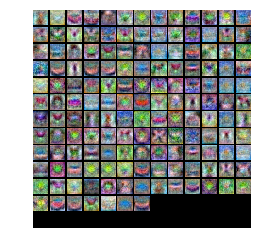

the size of hidden layer is 150
learning rate is 1.000000e-03
regularizaiton strength is 1.000000


In [16]:
# visualize the weights of the best network
show_net_weights(best_net)
# network structure
print('the size of hidden layer is %d' % best_setting[0])
print('learning rate is %e' % best_setting[1])
print('regularizaiton strength is %f' % best_setting[2])

#interations: 24500


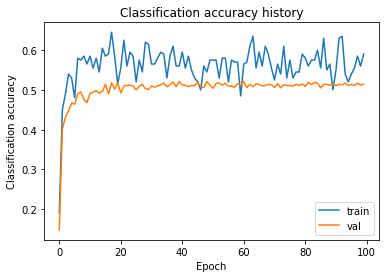

In [27]:
# train network again with the best setting and 100 epchoes
two_layer_net = TwoLayerNet(D, hiddensize, num_classes)
hiddensize, lr, reg = best_setting
batch_size = 200
num_epcho = 100
num_iters = int(num_epcho * X_train.shape[0]/batch_size)
print('#interations: %d' % num_iters)

stats = two_layer_net.train(X_train, y_train, X_val, y_val,
                            num_iters=num_iters, batch_size=batch_size,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=False)

# keep trace of hyperparameters tunning
train_acc_history = stats['train_acc_history']
train_acc100 = train_acc_history[-1]
val_acc_history = stats['val_acc_history']
val_acc100 = val_acc_history[-1]

# plot training accuracy and validation accuracy
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [28]:
# save the above 2-layer neoral network (trained with 100 epchoes)
best_net100 = deepcopy(two_layer_net)
print('info of best_net100:')
print('train accuracy: %f validation accuracy: %f' % (train_acc100, val_acc100))

info of best_net100:
train accuracy: 0.590000 validation accuracy: 0.515000


#interations: 245000


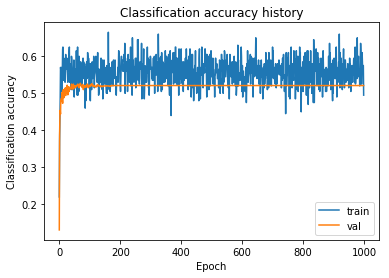

In [23]:
# train network again with the best setting and 1000 epchoes
two_layer_net = TwoLayerNet(D, hiddensize, num_classes)
hiddensize, lr, reg = best_setting
batch_size = 200
num_epcho = 1000
num_iters = int(num_epcho * X_train.shape[0]/batch_size)
print('#interations: %d' % num_iters)

stats = two_layer_net.train(X_train, y_train, X_val, y_val,
                            num_iters=num_iters, batch_size=batch_size,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=False)

# keep trace of hyperparameters tunning
train_acc_history = stats['train_acc_history']
train_acc1000 = train_acc_history[-1]
val_acc_history = stats['val_acc_history']
val_acc1000 = val_acc_history[-1]

# plot training accuracy and validation accuracy
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [26]:
# save the above 2-layer neoral network (trained with 1000 epchoes)
best_net1000 = deepcopy(two_layer_net)
print('info of best_net1000:')
print('train accuracy: %f validation accuracy: %f' % (train_acc1000, val_acc1000))

info of best_net1000:
train accuracy: 0.495000 validation accuracy: 0.521000


# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [29]:
# test on best_net
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy of best_net: ', test_acc)

# test on best_net100 (trained with the same lr ang reg, but larger #epcho = 100)
test_acc = (best_net100.predict(X_test) == y_test).mean()
print('Test accuracy of best_net100: ', test_acc)

# test on best_net100 (trained with the same lr ang reg, but larger #epcho = 1000)
test_acc = (best_net1000.predict(X_test) == y_test).mean()
print('Test accuracy of best_net1000: ', test_acc)

Test accuracy of best_net:  0.483
Test accuracy of best_net100:  0.538
Test accuracy of best_net1000:  0.532


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$3

$\color{blue}{\textit Your Explanation:}$
increasing regularization strength can penaltize large weigths, thus aviod overfitting to same extend

